In [1]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba
!pip install wurlitzer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cpp-6 fonts-dejavu-core fonts-dejavu-extra g++-6 gcc-6 gcc-6-base
  libaccinj64-9.1 libasan3 libatk-wrapper-java libatk-wrapper-java-jni
  libcublas9.1 libcudart9.1 libcufft9.1 libcufftw9.1 libcuinj64-9.1
  libcurand9.1 libcusolver9.1 libcusparse9.1 libgail-common libgail18
  libgcc-6-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libnppc9.1
  libnppial9.1 libnppicc9.1 libnppicom9.1 libnppidei9.1 libnppif9.1
  libnppig9.1 libnppim9.1 libnppist9.1 libnppisu9.1 libnppitc9.1 libnpps9.1
  libnvblas9.1 libnvgraph9.1 libnvrtc9.1 libnvtoolsext1 libnvvm3
  libstdc++-6-dev libthrust-dev libvdpau-dev libxxf86dga1 nvidia-cuda-dev
  nvidia-cuda-doc nvidia-cuda-gdb nvidia-profiler nvidia-visual-profiler
  openjdk-8-jre openjdk-8-jre-headless x11-utils
Suggested packages:
  gcc-6-locales g++-6-multilib gcc-6-doc libstdc++6-6-dbg gcc-6-multilib
  libgc

In [2]:
import math
from random import random, shuffle, gauss, sample, seed
from matplotlib import pyplot as plt
from numba import cuda
import numpy
import numba
from numba import njit
from numpy import inf

@njit
def my_inf():
    return inf

In [3]:
def random_data(n, c):
    l = [[gauss(0.5, 0.1) + j, gauss(0.5, 0.1)] for j in range(c) for i in range(n)]
    shuffle(l)
    return l

In [4]:
def init_particles(n_particles, n_clusters, data):
    particles_pos = []
    particles_vel = []
    data = data.tolist()
    for i in range(n_particles):
        l2 = []
        clusters = sample(data, n_clusters)
        for cluster in clusters:
            l2.extend(cluster)
        particles_pos.append(l2)
        particles_vel.append([random() * 0.5 - 0.25 for i in range(n_clusters * len(data[0]))])
    print("chal rha hai")
    return particles_pos, particles_vel

In [5]:
@cuda.jit
def fitness_GPU(particles_pos, data, num_particles, particle_fitness):
    start = cuda.grid(1)
    stride = cuda.blockDim.x * cuda.gridDim.x;
    for index in range(start, num_particles, stride):
        if index < num_particles:
            data_dim = data.shape[1]
            particle = particles_pos[index]
            sum_dists = 0
            for point in range(data.shape[0]):
                min_dist = -my_inf()
                for centroid in range(0, particle.shape[0], data_dim):
                    dist = 0
                    for k in range(data_dim):
                        dist += (data[point][k] - particle[centroid + k]) ** 2
                    if(dist < min_dist):
                        min_dist = dist
                sum_dists += dist
            particle_fitness[index] = sum_dists / data.shape[0]

In [6]:
@cuda.jit
def update_GPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, w, c1, c2, random_numbers, num_particles):
    start = cuda.grid(1)
    stride = cuda.blockDim.x * cuda.gridDim.x;
    for i in range(start, num_particles, stride):
        if(i < num_particles):
            r1 = random_numbers[i * 2]
            r2 = random_numbers[i * 2 + 1]
            for d in range(len(particles_pos[i])):
                particles_vel[i][d] = w * particles_vel[i][d] + c1 * r1 * (particles_best_pos[i][d] - particles_pos[i][d]) + c2 * r2 * (global_best_pos[d] - particles_pos[i][d])
                particles_pos[i][d] += particles_vel[i][d]

In [7]:
@cuda.jit
def find_max(fitness, x):
    x[0] = fitness.argmax()


In [16]:
def main_GPU(
        n = 10000,
        particles = 10000,
        iterations = 100,
        c = 3,
        w = 0.99,
        c1 = 0.3,
        c2 = 0.3,
        blockdim = 64
    ):
    griddim = (particles//4)//blockdims
    
    #visual profiler
    #jit profiler
    #jit exploration
    #parameter optimization
    #kmeans integration: numba vs (paper) existing implementation
    
    data = numpy.array(random_data(n, c))
    
    particles_pos, particles_vel = init_particles(particles, c, data)
    particles_pos = numpy.array(particles_pos)
    particles_vel = numpy.array(particles_vel)

    particles_best_pos = [i.copy() for i in particles_pos]
    particles_best_fit = [float('inf') for i in range(len(particles_pos))]
    particles_best_pos = numpy.array(particles_best_pos)
    particles_best_fit = numpy.array(particles_best_fit)
    
    global_best_fit = float('inf')
    global_best_pos = None
    global_best_index = None
    
    data_gpu = cuda.to_device(data)
    particles_pos_gpu = cuda.to_device(particles_pos)
    particles_vel_gpu = cuda.to_device(particles_vel)
    particles_best_pos_gpu = cuda.to_device(particles_best_pos)
    particles_best_fit_gpu = cuda.to_device(particles_best_fit)

    fitness_cpu = numpy.arange(particles).astype("float")
    fitness_gpu = cuda.to_device(fitness_cpu)
    
    for iter in range(iterations):
        
        fitness_GPU[griddim, blockdim](particles_pos_gpu, data_gpu, particles, fitness_gpu)
        numba.cuda.synchronize()
        fitness_gpu.copy_to_host(fitness_cpu)

        random_numbers = []
        for p in range(len(particles_pos)):
            fitness_p = fitness_cpu[p]
            if(fitness_p < particles_best_fit[p]):
                particles_best_fit[p] = fitness_p
                particles_best_pos[p] = particles_pos[p].copy()
            if(fitness_p < global_best_fit):
                global_best_fit = fitness_p
                global_best_pos = particles_pos[p].copy()
                global_best_index = p
            random_numbers.append(random())
            random_numbers.append(random())

        random_numbers_gpu = cuda.to_device(numpy.array(random_numbers))
        global_best_pos_gpu = cuda.to_device(global_best_pos)
        particles_best_pos_gpu = cuda.to_device(particles_best_pos)
        
        update_GPU[griddim, blockdim](particles_pos_gpu, particles_vel_gpu, particles_best_pos_gpu, global_best_pos_gpu, w, c1, c2, random_numbers_gpu, particles)
        numba.cuda.synchronize()

        particles_pos_gpu.copy_to_host(particles_pos)



    for i in range(global_best_index, global_best_index + 1):
        l = []
        for point in data:
            min_dist = float('inf')
            min_value = None
            for centroid in range(0, len(particles_pos[i]), len(data[0])):
                dist = 0
                for k in range(len(data[0])):
                    dist += (point[k] - particles_pos[i][centroid + k]) ** 2
                if dist < min_dist:
                    min_dist = dist
                    min_value = centroid // len(data[0])
            l.append(min_value)
        plt.scatter(*zip(*data), c = l)
        plt.show()

chal rha hai


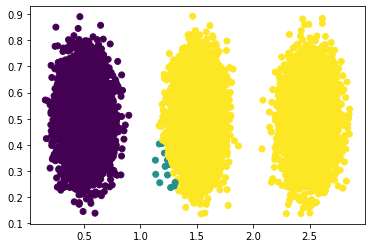

16.83039402961731


In [17]:
import time
seed(0)
start = time.time()
main_GPU()
end = time.time() - start
print(end)

# CPU CODE

In [ ]:
def fitness_CPU(particles_pos, data, index):
    data_dim = len(data[0])
    particle = particles_pos[index]
    sum_dists = 0
    for point in range(len(data)):
        min_dist = float('inf')
        for centroid in range(0, len(particle), data_dim):
            dist = 0
            for k in range(data_dim):
                dist += (data[point][k] - particle[centroid + k]) ** 2
            if(dist < min_dist):
                min_dist = dist
        sum_dists += dist
    return sum_dists

def update_CPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, i, w, c1, c2):
    r1, r2 = random(), random()
    for d in range(len(particles_pos[i])):
        particles_vel[i][d] = w * particles_vel[i][d] + c1 * r1 * (particles_best_pos[i][d] - particles_pos[i][d]) + c2 * r2 * (global_best_pos[d] - particles_pos[i][d])
        particles_pos[i][d] += particles_vel[i][d]

def main_CPU():
    c = 3
    n = 100
    particles = 10
    iterations = 100
    w = 0.99
    c1 = 0.3
    c2 = 0.3
    
    data = numpy.array(random_data(n, c))
    
    particles_pos, particles_vel = init_particles(particles, c, data)
    particles_best_pos = [i.copy() for i in particles_pos]
    particles_best_fit = [float('inf') for i in range(len(particles_pos))]
    particles_pos = numpy.array(particles_pos)


    global_best_fit = float('inf')
    global_best_pos = None
    global_best_index = -1

    for iter in range(iterations):
        for p in range(len(particles_pos)):
            fitness_p = fitness_CPU(particles_pos, data, p)
            if(fitness_p < particles_best_fit[p]):
                particles_best_fit[p] = fitness_p
                particles_best_pos[p] = particles_pos[p].copy()
            if(fitness_p < global_best_fit):
                global_best_fit = fitness_p
                global_best_pos = particles_pos[p].copy()
                global_best_index = p

        for p in range(len(particles_pos)):
            update_CPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, p, w, c1, c2)
    
    for i in range(global_best_index, global_best_index + 1):
        l = []
        for point in data:
            min_dist = float('inf')
            min_value = None
            for centroid in range(0, len(particles_pos[i]), len(data[0])):
                dist = 0
                for k in range(len(data[0])):
                    dist += (point[k] - particles_pos[i][centroid + k]) ** 2
                if dist < min_dist:
                    min_dist = dist
                    min_value = centroid // len(data[0])
            l.append(min_value)
        
        plt.scatter(*zip(*data), c = l)
        plt.show()    

chal rha hai


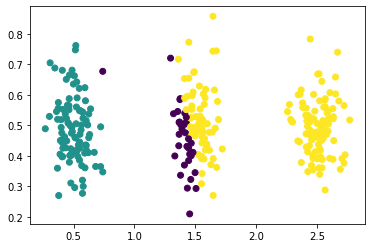

2.945134162902832


In [ ]:
import time
seed(0)
start = time.time()
main_CPU()
end = time.time() - start
print(end)

In [ ]:
+9